# Primera entrega NBA Salaries

### Integrantes:

- Nicolas Biojo &ensp; A00137580 sis
- Cristian Cobo &ensp;A00348619 sis
- David Erazo &emsp; A00130528 sis   

# Análisis de calidad de los datos

En una primera instancia, se cargaron en un dataframe de pandas el dataset que contiene estadisticas avanzadas del rendiemiento de los jugadores de la NBS durante la temporada 2017-2018. 

In [133]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors, datasets, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import decomposition
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [134]:
data = pd.read_csv('2017-18_NBA_salary.csv')
data.head()

,Player,Salary,NBA_Country,NBA_DraftNumber,Age,Tm,G,MP,PER,TS%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Zhou Qi,815615,China,43,22,HOU,16,87,0.6,0.303,...,18.2,19.5,-0.4,0.1,-0.2,-0.121,-10.6,0.5,-10.1,-0.2
1,Zaza Pachulia,3477600,Georgia,42,33,GSW,66,937,16.8,0.608,...,19.3,17.2,1.7,1.4,3.1,0.160,-0.6,1.3,0.8,0.7
2,Zach Randolph,12307692,USA,19,36,SAC,59,1508,17.3,0.529,...,12.5,27.6,0.3,1.1,1.4,0.046,-0.6,-1.3,-1.9,0.0
3,Zach LaVine,3202217,USA,13,22,CHI,24,656,14.6,0.499,...,9.7,29.5,-0.1,0.5,0.4,0.027,-0.7,-2.0,-2.6,-0.1
4,Zach Collins,3057240,USA,10,20,POR,62,979,8.2,0.487,...,15.6,15.5,-0.4,1.2,0.8,0.038,-3.7,0.9,-2.9,-0.2


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 28 columns):
Player             485 non-null object
Salary             485 non-null int64
NBA_Country        485 non-null object
NBA_DraftNumber    485 non-null int64
Age                485 non-null int64
Tm                 485 non-null object
G                  485 non-null int64
MP                 485 non-null int64
PER                485 non-null float64
TS%                483 non-null float64
3PAr               483 non-null float64
FTr                483 non-null float64
ORB%               485 non-null float64
DRB%               485 non-null float64
TRB%               485 non-null float64
AST%               485 non-null float64
STL%               485 non-null float64
BLK%               485 non-null float64
TOV%               483 non-null float64
USG%               485 non-null float64
OWS                485 non-null float64
DWS                485 non-null float64
WS                 485 non-n

Previo al análisis, se identificaron las variables cuantitativas y categoricas apartir del método .info(). Adicionalmente, este método nos permitió evidenciar la existencia de missing values a partir del número de registros por variable, los cuales fueron: TS%, 3PAr, FTr y TOV% en los registros 29 y 37.

### Búsqueda de valores nulos

In [136]:
mColums = pd.isnull(data).any(0).to_numpy().nonzero()[0]
print("Missing values: ")
for col in mColums:
    print ("  index {} name {}".format(col,data.columns[col]))

Missing values: 
  index 9 name TS%
  index 10 name 3PAr
  index 11 name FTr
  index 18 name TOV%


In [137]:
index = pd.isnull(data).any(1).to_numpy().nonzero()[0]
print("{} incomplete records:".format(len(index)), index)

2 incomplete records: [29 37]


In [138]:
originalData = data.copy()
data = data.dropna()
print("Datos originales: ", originalData.shape)
print("Datos limpios y completos: ", data.shape)
print("Se eliminaron {} registos".format(originalData.shape[0] - data.shape[0]))

Datos originales:  (485, 28)
Datos limpios y completos:  (483, 28)
Se eliminaron 2 registos


### Análisis de variables relevantes

Acontinuación, se lleva acabo un análisis sobre las variables de mayor relevancia para identificar inconsistencias o datos erronoes. 

- Player: Podemos ver que existen jugadores en varios equipos. En este caso el jugador Kay Felder se encuentra en los equipos: DET,CHI y TOT.
- NBA_Country: No existen dos o más labels distintos para representar un mismo país.
- Age: No existe ningun jugador el cual sea menor de 18 años.
- Salary: Todos los pagos a los jugadores son valores positivos.
- TS%: Se logra identificar un posible dato erroneo el cual determina un 150%. 
- G: Todas las cantidades de partidos jugados son valores positivos.
- MP: Todos los valores referentes a los minutos jugados son valores positivos.
- OWS: Los valores referentes al número estimado de victorias por un desempeño ofensivo presenta valores positivos como                negativos, donde suponemos que los negativos representan las derrotas. 
- DWS: Los valores referentes al número estimado de victorias por un desempeño defensivo presenta valores positivos
- WS: Los valores referentes al número estimado de victorias contribuidas por un jugador, presenta valores positivos como             negativos, donde suponemos que los negativos representan las derrotas. 

Busqueda de jugadores en más de un equipo 

In [139]:
data.describe()

,Salary,NBA_DraftNumber,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,...,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,6.660622e+06,29.395445,26.273292,50.370600,1158.915114,13.315735,0.535387,0.337383,0.263404,4.893996,...,13.140373,18.975569,1.280745,1.181366,2.465424,0.080325,-1.252588,-0.489441,-1.741822,0.601242
std,7.398214e+06,21.116033,4.274290,24.723561,809.627553,8.745666,0.112352,0.226894,0.294578,4.581519,...,6.115290,5.826533,1.883545,1.033939,2.674520,0.163229,5.028752,2.394156,5.665905,1.247636
min,4.608000e+04,1.000000,19.000000,1.000000,1.000000,-41.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.700000,-2.300000,0.000000,-1.200000,-1.063000,-36.500000,-14.300000,-49.200000,-1.300000
25%,1.471382e+06,10.500000,23.000000,29.500000,385.000000,9.800000,0.505500,0.167000,0.155000,1.800000,...,9.900000,15.000000,0.000000,0.300000,0.300000,0.040500,-2.600000,-1.700000,-3.500000,-0.100000
50%,3.218280e+06,25.000000,26.000000,59.000000,1151.000000,13.200000,0.545000,0.346000,0.231000,3.300000,...,12.500000,17.900000,0.800000,1.000000,1.900000,0.083000,-1.100000,-0.400000,-1.300000,0.100000
75%,1.000000e+07,47.000000,29.000000,71.000000,1824.500000,16.550000,0.582500,0.481000,0.319500,7.050000,...,15.750000,22.250000,2.000000,1.800000,3.600000,0.123000,0.400000,1.000000,0.550000,0.900000
max,3.468255e+07,62.000000,41.000000,79.000000,2898.000000,134.100000,1.500000,1.000000,5.333000,35.900000,...,66.700000,45.100000,11.400000,5.600000,15.000000,2.713000,68.700000,6.800000,54.400000,8.600000


In [140]:
data["NBA_Country"].unique()

array(['China', 'Georgia', 'USA', 'Canada', 'Spain', 'France',
       'Czech Republic', 'Russia', 'South Sudan', 'Switzerland',
       'New Zealand', 'Haiti', 'Democratic Re_', 'Tunisia', 'Brazil',
       'Germany', 'Australia', 'Cameroon', 'Israel', 'Turkey',
       'United Kingdo...', 'Montenegro', 'Serbia', 'Argentina', 'Bosnia',
       'Lithuania', 'Croatia', 'Italy', 'Poland', 'Dominican Rep...',
       'Finland', 'Latvia', 'Bosnia & Herz...', 'Sweden', 'Ukraine',
       'Austria', 'Puerto Rico', 'Senegal', 'Slovenia', 'Greece',
       'Democratic Re...', 'Mali', 'Bahamas', 'Egypt'], dtype=object)

In [141]:
print ("Menores de edad: {}".format(data.loc[data.Age < 18].shape[0]))

Menores de edad: 0


In [142]:
playersNba = data.iloc[:,0]
boolPlayersDuplicated = playersNba.duplicated()

i = 0
for x in boolPlayersDuplicated: 
    i +=1
    if(x == True):
        print(data.iloc[lambda m: m.index  == i].Player)
   


224    Kay Felder
Name: Player, dtype: object
225    Kay Felder
Name: Player, dtype: object


# Visualización de datos

En la siguiente matriz de correlación podemos identificar las relaciones entre todas las variables, donde los slots más claros representan un valor porcentaul de relación más alto. Mientras que los slots más oscuros representan una relación inversamente proporcional entre las variables. 


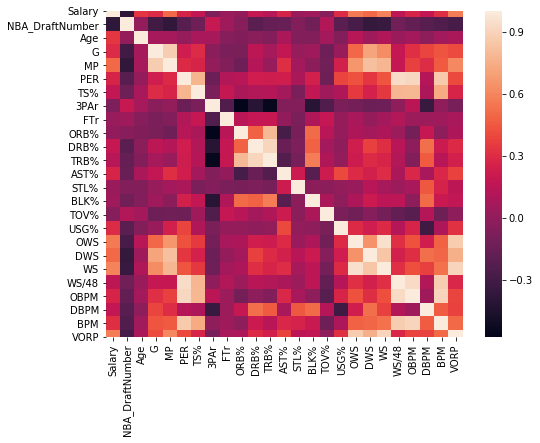

<Figure size 7200x4320 with 0 Axes>

In [143]:
fig = plt.figure(figsize=(8,6))
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=False)
plt.figure(figsize=(100,60))
plt.show()

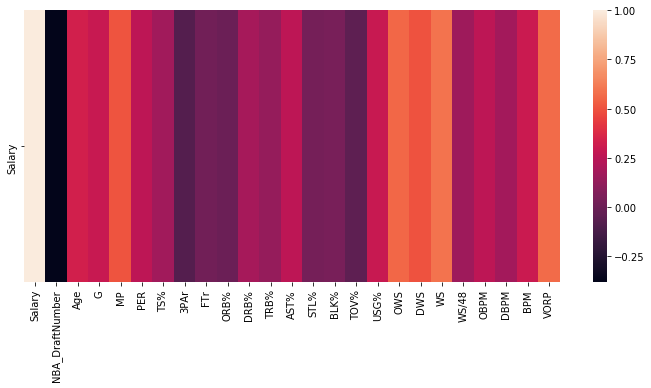

In [144]:
fig = plt.figure(figsize=(12,5))
sn.heatmap(corrMatrix[:1], annot=False)
plt.show()

Para evaluar la relación entre el salario de los jugadores y el resto de variables, realizamos la siguiente matriz de correlación, la cual nos permitio identificar las variables que están más relacionadas con esta:


- MP: Minutos jugados

- OWS: Offensive Win Shares (número estimado de victorias contribuidas por un jugador dado su desempeño ofensivo)

- DWS: Defensive Win Shares (número estimado de victorias contribuidas por un jugador dado su desempeño defensivo)

- WS: Win Shares (número estimado de victorias contribuidas por un jugador)

- VORP: Value Over Replacement Player (métrica para medir la contribución total de un jugador al equipo)



## Análsis diagrama de Cajas y Bigotes

A continuación, por cada una de las variables que seleccionamos, las representamos por medio de diagramas de caja para poder observar la distribución de cada una de estas. 

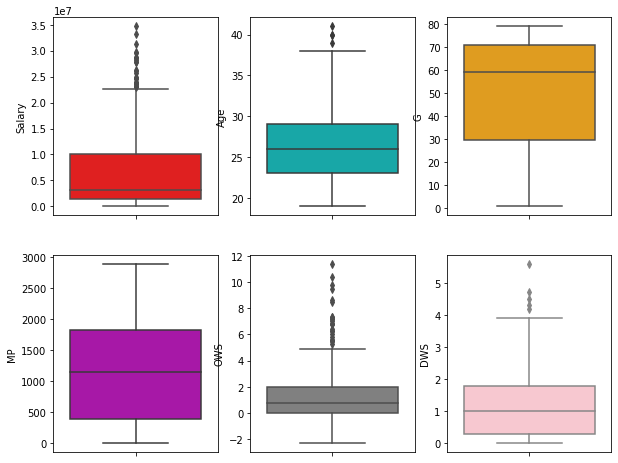

In [145]:
fig = plt.figure(figsize=(10,8))

plt.subplot(2,3,1)
sn.boxplot('Salary', data=data, orient='v', color="r")

plt.subplot(2,3,2)
sn.boxplot('Age', data=data, orient='v', color="c")

plt.subplot(2,3,3)
sn.boxplot('G', data=data, orient='v', color="orange")

plt.subplot(2,3,4)
sn.boxplot('MP', data=data, orient='v', color="m")

plt.subplot(2,3,5)
sn.boxplot('OWS', data=data, orient='v', color="gray")

plt.subplot(2,3,6)
sn.boxplot('DWS', data=data, orient='v', color="pink")

- Como se puede obsevar en el anterior diagrama de cajas y bigotes de la variable "Salary" al menos el 50% de los jugadores gana en promedio entre 0.25 y 0.3 millones de dolares.

- En cuanto se refiere a la variable "Age" se puede afirmar que, al menos el 50% de los jugadores tienen una edad entre 26 y 27 años. Además tambien se puede decir que al menos el 75% de los jugadores tienen una edad menor a 30 años. 

- Si observamos el diagrama de cajas de la variable "G"(No. de partidos jugados) podemos ver que al menos el 50% de los jugadores de la temporada NBA 2017-2018 jugaron aproxidamente 60 partidos. Y al menos el 25% de estos jugadores tuvieron aproximadamente el 30 partidos. 

- Ahora bien, si analizamos el grafico de la variable "MP"(Minutos jugados) podemos ver que este particular se diferencia de los demás puesto a aque su sesgo tiende a ser simétrico. Tambien se puede decir que al menos el 50% de los jugadores de la temporada 18-17 de la NBA  ha jugado aproximadamente 1200 minutos. Y al menos el 75% ha jugado entre 1800 y 1900 minutos.

- En el diagrama de cajas de la variable "OWS" (Número estimado de victorias contribuidas por un jugador dado su desempeño ofensivo) se puede ver que existe una gran cantidad de datos atípicos. Estos puntos atípicos representan alto número de vitorias dado al buen desempeño ofensivo de ese jugador. 

- El diagrama de caja de la variable "DWS" al igual que lz variable "OWS" tambien tiende a tener sesgo negativo. Y al menos el 50% de los jugadores cuentan con un puntaje de 1 para esta variable.







## Análisis de Histogramas 
### Distribuciones: Salary, Age y Mp(Minutos jugados)

Text(0.5, 1.0, 'MP')

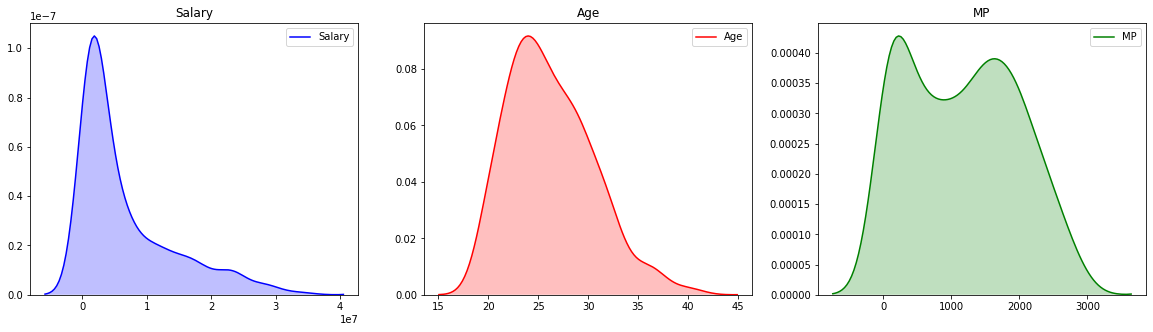

In [146]:
fig = plt.figure(figsize=(20,5))

d = data.iloc[:,1]
plt.subplot(1,3,1)
ax = sn.kdeplot(d, shade=True, color="b")
ax.set_title("Salary")

d = data.iloc[:,4]
plt.subplot(1,3,2)
ax = sn.kdeplot(d, shade=True, color="r")
ax.set_title("Age")

d = data.iloc[:,7]
plt.subplot(1,3,3)
ax = sn.kdeplot(d, shade=True, color="g")
ax.set_title("MP")


- Gráfico 1: La variable "Salary" tiende a tener una distribución Chi - Cuadrada
- Gráfico 2: La variable "Age" tiende a tener una distribución Normal
- Gráfico 3: La varivale "Mp" (Minutos jugados) tiende a tener una distribución Bimodal. 

# Limpieza de datos

La limpieza de datos es un proceso necesario para asegurar la calidad de los datos. Este paso es muy importante para minimizar el error al basarnos en información poco precisa, errónea o incompleta.

In [147]:
data.dtypes

Player              object
Salary               int64
NBA_Country         object
NBA_DraftNumber      int64
Age                  int64
Tm                  object
G                    int64
MP                   int64
PER                float64
TS%                float64
3PAr               float64
FTr                float64
ORB%               float64
DRB%               float64
TRB%               float64
AST%               float64
STL%               float64
BLK%               float64
TOV%               float64
USG%               float64
OWS                float64
DWS                float64
WS                 float64
WS/48              float64
OBPM               float64
DBPM               float64
BPM                float64
VORP               float64
dtype: object

In [148]:
data['Player']=data['Player'].astype('category')
data['NBA_Country']=data['NBA_Country'].astype('category')
data['Tm']=data['Tm'].astype('category')
data.dtypes

Player             category
Salary                int64
NBA_Country        category
NBA_DraftNumber       int64
Age                   int64
Tm                 category
G                     int64
MP                    int64
PER                 float64
TS%                 float64
3PAr                float64
FTr                 float64
ORB%                float64
DRB%                float64
TRB%                float64
AST%                float64
STL%                float64
BLK%                float64
TOV%                float64
USG%                float64
OWS                 float64
DWS                 float64
WS                  float64
WS/48               float64
OBPM                float64
DBPM                float64
BPM                 float64
VORP                float64
dtype: object

Para las variables Player, NBA_Country y Tm se les modificó el tipo de variable object a categorica, ya que esto facilita la ejecución de los modelos.

In [149]:
numHeaders = ['Salary', 'NBA_DraftNumber', 'Age','G','MP', 'PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','OBPM','DBPM','BPM','VORP']
print("Datos antes de eliminar valores atípicos: ", data.shape)

for header in numHeaders:
    print("Valores atípicos de la variable "+header+":",len(data[abs(data[header])>(data[header].mean()+(data[header].std()*4))]))
    data.drop(data[abs(data[header])>(data[header].mean()+(data[header].std()*5))].index,inplace=True)
print("Datos despúes de eliminar valores atípicos: ", data.shape)
    

Datos antes de eliminar valores atípicos:  (483, 28)
Valores atípicos de la variable Salary: 0
Valores atípicos de la variable NBA_DraftNumber: 0
Valores atípicos de la variable Age: 0
Valores atípicos de la variable G: 0
Valores atípicos de la variable MP: 0
Valores atípicos de la variable PER: 1
Valores atípicos de la variable TS%: 1
Valores atípicos de la variable 3PAr: 0
Valores atípicos de la variable FTr: 3
Valores atípicos de la variable ORB%: 3
Valores atípicos de la variable DRB%: 0
Valores atípicos de la variable TRB%: 0
Valores atípicos de la variable AST%: 1
Valores atípicos de la variable STL%: 4
Valores atípicos de la variable BLK%: 3
Valores atípicos de la variable TOV%: 4
Valores atípicos de la variable USG%: 1
Valores atípicos de la variable OWS: 4
Valores atípicos de la variable DWS: 1
Valores atípicos de la variable WS: 3
Valores atípicos de la variable OBPM: 3
Valores atípicos de la variable DBPM: 3
Valores atípicos de la variable BPM: 4
Valores atípicos de la varia

# Normalización de datos

In [150]:
data.mean()

Salary             6.679625e+06
NBA_DraftNumber    2.880172e+01
Age                2.625000e+01
G                  5.183405e+01
MP                 1.188239e+03
PER                1.332888e+01
TS%                5.379289e-01
3PAr               3.365841e-01
FTr                2.496875e-01
ORB%               4.761422e+00
DRB%               1.512953e+01
TRB%               9.942026e+00
AST%               1.309073e+01
STL%               1.539440e+00
BLK%               1.745474e+00
TOV%               1.291940e+01
USG%               1.869375e+01
OWS                1.274353e+00
DWS                1.206034e+00
WS                 2.483405e+00
WS/48              8.149784e-02
OBPM              -1.170043e+00
DBPM              -3.185345e-01
BPM               -1.488362e+00
VORP               5.745690e-01
dtype: float64

In [151]:
data.std()

Salary             7.228285e+06
NBA_DraftNumber    2.070923e+01
Age                4.305554e+00
G                  2.352005e+01
MP                 7.876955e+02
PER                5.405647e+00
TS%                8.116664e-02
3PAr               2.174981e-01
FTr                1.400043e-01
ORB%               3.932997e+00
DRB%               6.476931e+00
TRB%               4.762164e+00
AST%               8.594776e+00
STL%               7.830387e-01
BLK%               1.602988e+00
TOV%               4.781969e+00
USG%               5.199006e+00
OWS                1.788084e+00
DWS                1.011813e+00
WS                 2.554496e+00
WS/48              7.418225e-02
OBPM               2.831569e+00
DBPM               2.002989e+00
BPM                3.605365e+00
VORP               1.119511e+00
dtype: float64

In [152]:
stdsc = StandardScaler()
x = data[numHeaders].values
x_scaled = stdsc.fit_transform(x)
data_t = pd.DataFrame(x_scaled, columns=numHeaders, index=data.index)
dataN = data.copy()
dataN[numHeaders] = data_t

In [153]:
dataN.mean()

Salary             2.799485e-17
NBA_DraftNumber    9.750342e-18
Age                9.570888e-18
G                  9.475179e-17
MP                 1.493059e-16
PER               -2.536285e-17
TS%               -1.866323e-17
3PAr              -1.775400e-16
FTr                1.914178e-16
ORB%               2.742059e-16
DRB%              -1.493059e-16
TRB%              -2.012279e-16
AST%              -1.125178e-16
STL%               1.810094e-16
BLK%               1.660549e-16
TOV%               1.091081e-16
USG%              -2.897586e-16
OWS               -6.460349e-18
DWS                1.488273e-16
WS                 1.019300e-16
WS/48              8.149784e-02
OBPM               3.529265e-18
DBPM              -7.178166e-18
BPM               -4.354754e-17
VORP              -9.068417e-17
dtype: float64

In [154]:
dataN.std()

Salary             1.001079
NBA_DraftNumber    1.001079
Age                1.001079
G                  1.001079
MP                 1.001079
PER                1.001079
TS%                1.001079
3PAr               1.001079
FTr                1.001079
ORB%               1.001079
DRB%               1.001079
TRB%               1.001079
AST%               1.001079
STL%               1.001079
BLK%               1.001079
TOV%               1.001079
USG%               1.001079
OWS                1.001079
DWS                1.001079
WS                 1.001079
WS/48              0.074182
OBPM               1.001079
DBPM               1.001079
BPM                1.001079
VORP               1.001079
dtype: float64

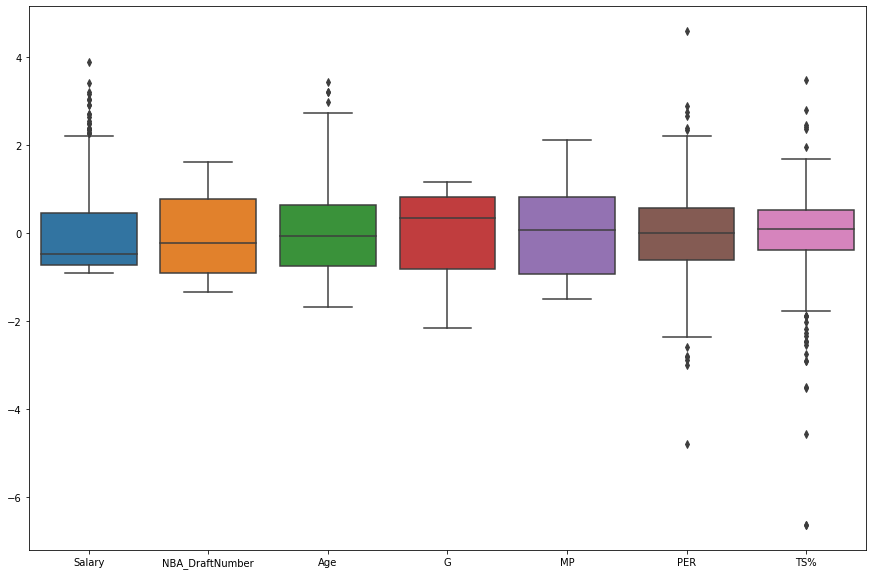

In [155]:
plt.rc('figure',figsize=(15,10))
sn.boxplot( orient= "v", data=dataN[numHeaders[0:7]])

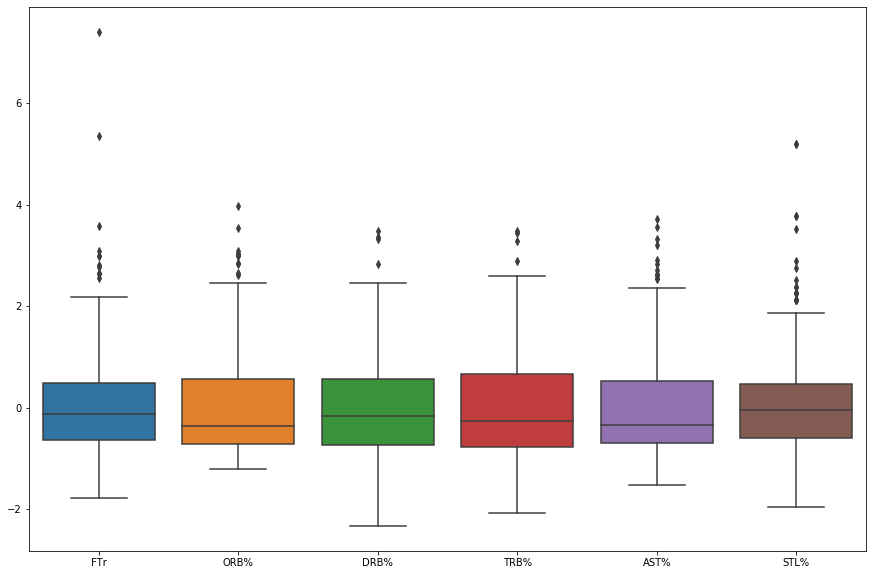

In [156]:
sn.boxplot( orient= "v", data=dataN[numHeaders[8:14]])

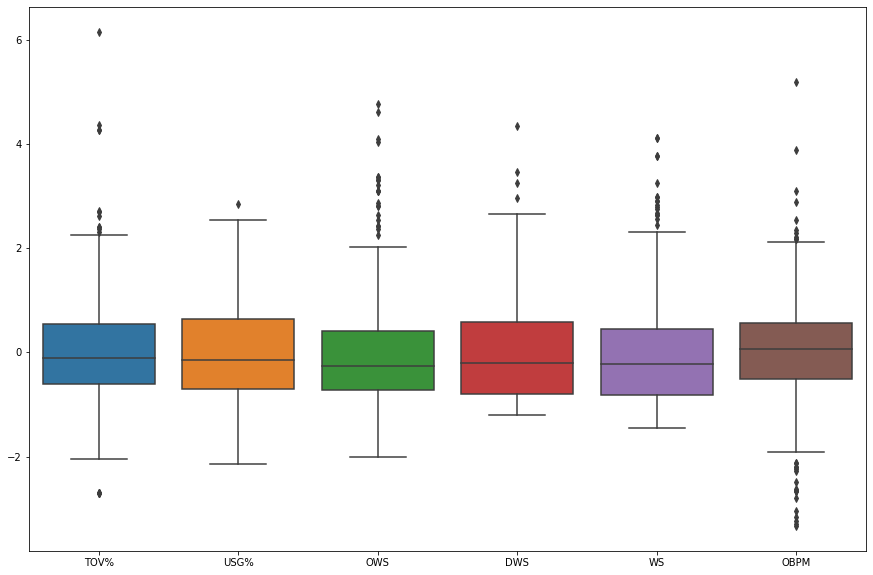

In [157]:
sn.boxplot( orient= "v", data=dataN[numHeaders[15:21]])

Luego de haber normalizado los datos y de su posterior visualización en diagrama de cajas, se logra identificar que la mayoria de datos atípicos se encuentran por fuera del rango de -5 a 5 desviaciones estandar. Por lo tanto se opta por eliminar los datos los cuales estan fuera de este rango.

# Análisis para el modelamiento 

Text(0, 0.5, 'Rango')

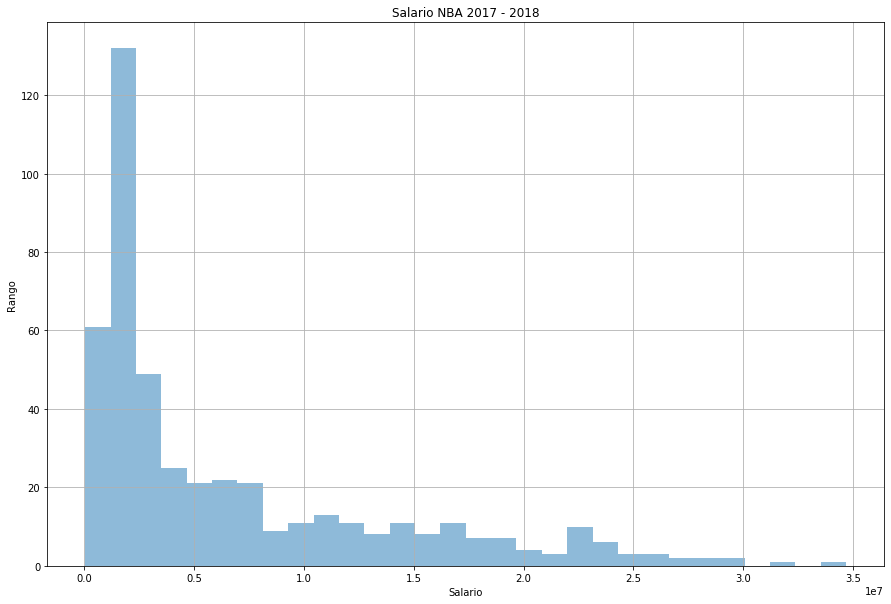

In [158]:
data.Salary.hist(bins=30, alpha=0.5)
plt.title("Salario NBA 2017 - 2018")
plt.xlabel("Salario")
plt.ylabel("Rango")

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 0 to 484
Data columns (total 28 columns):
Player             464 non-null category
Salary             464 non-null int64
NBA_Country        464 non-null category
NBA_DraftNumber    464 non-null int64
Age                464 non-null int64
Tm                 464 non-null category
G                  464 non-null int64
MP                 464 non-null int64
PER                464 non-null float64
TS%                464 non-null float64
3PAr               464 non-null float64
FTr                464 non-null float64
ORB%               464 non-null float64
DRB%               464 non-null float64
TRB%               464 non-null float64
AST%               464 non-null float64
STL%               464 non-null float64
BLK%               464 non-null float64
TOV%               464 non-null float64
USG%               464 non-null float64
OWS                464 non-null float64
DWS                464 non-null float64
WS                 464

Escribir el porque los 441 y análisis de la anterior tabla 

In [160]:
usaPlayers = data[data['NBA_Country'] == 'USA']
foreignPlayers = data[data['NBA_Country'] != 'USA']
print("El número de jugadores extranjeros de la NBA son: "+ str(foreignPlayers.Player.count()))

El número de jugadores extranjeros de la NBA son: 107


In [161]:
print("El número de jugadores de USA de la NBA son: "+ str( usaPlayers.Player.count()))

El número de jugadores de USA de la NBA son: 357


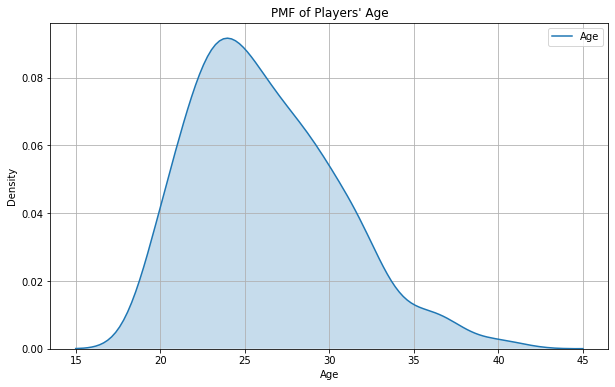

In [162]:
plt.figure(figsize=(10,6))
sn.kdeplot(data.Age, shade=True)
plt.title("PMF of Players' Age")
plt.ylabel("Density")
plt.xlabel('Age')
plt.grid(True)
plt.show()

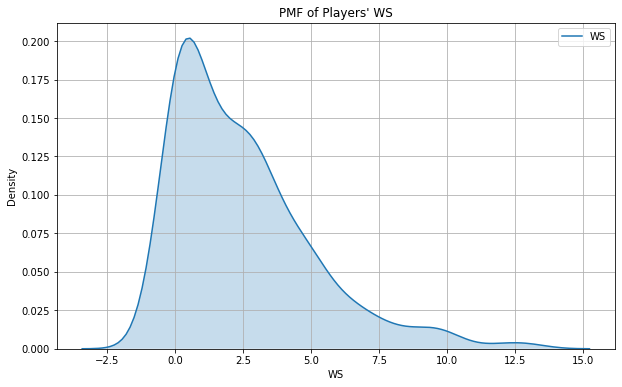

In [163]:
plt.figure(figsize=(10,6))
sn.kdeplot(data.WS, shade=True)
plt.title("PMF of Players' WS")
plt.ylabel("Density")
plt.xlabel('WS')
plt.grid(True)
plt.show()

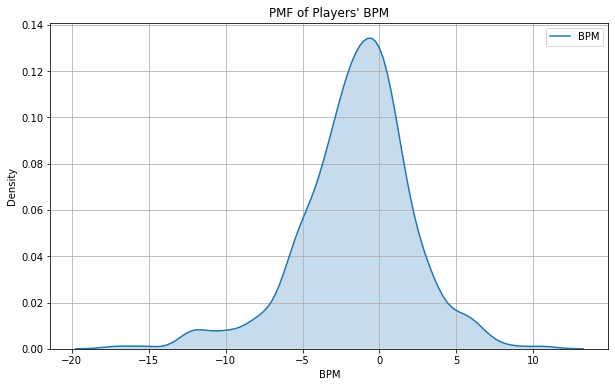

In [164]:
plt.figure(figsize=(10,6))
sn.kdeplot(data.BPM, shade=True)
plt.title("PMF of Players' BPM")
plt.ylabel("Density")
plt.xlabel('BPM')
plt.grid(True)
plt.show()

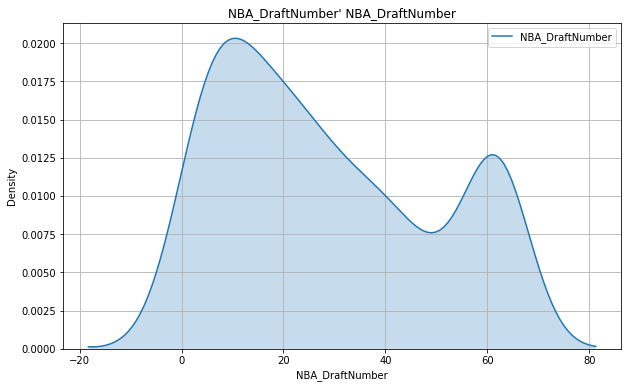

In [165]:
plt.figure(figsize=(10,6))
sn.kdeplot(data.NBA_DraftNumber, shade=True)
plt.title("NBA_DraftNumber' NBA_DraftNumber")
plt.ylabel("Density")
plt.xlabel('NBA_DraftNumber')
plt.grid(True)
plt.show()

In [166]:
print(data.columns)

Index(['Player', 'Salary', 'NBA_Country', 'NBA_DraftNumber', 'Age', 'Tm', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP'],
      dtype='object')


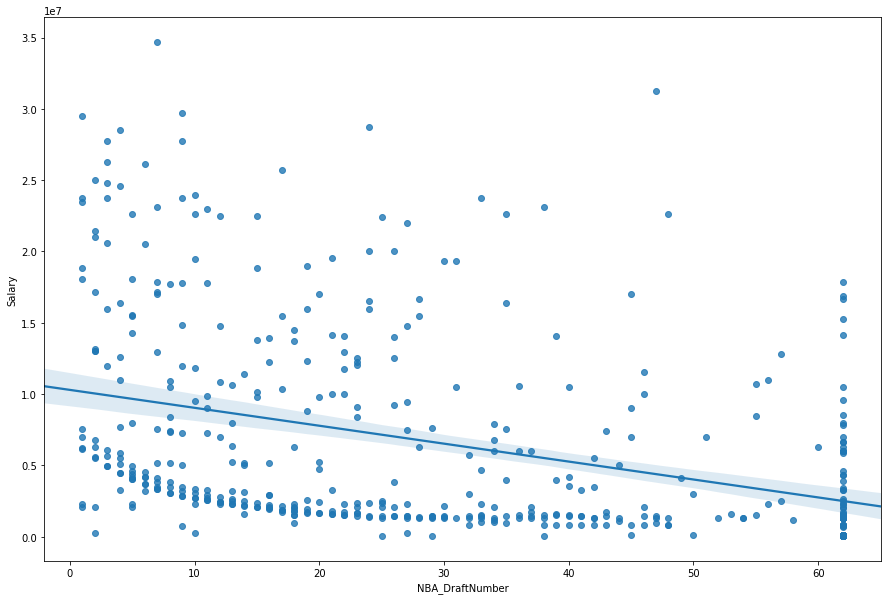

In [167]:
ax=sn.regplot(x='NBA_DraftNumber',y='Salary',data=data)

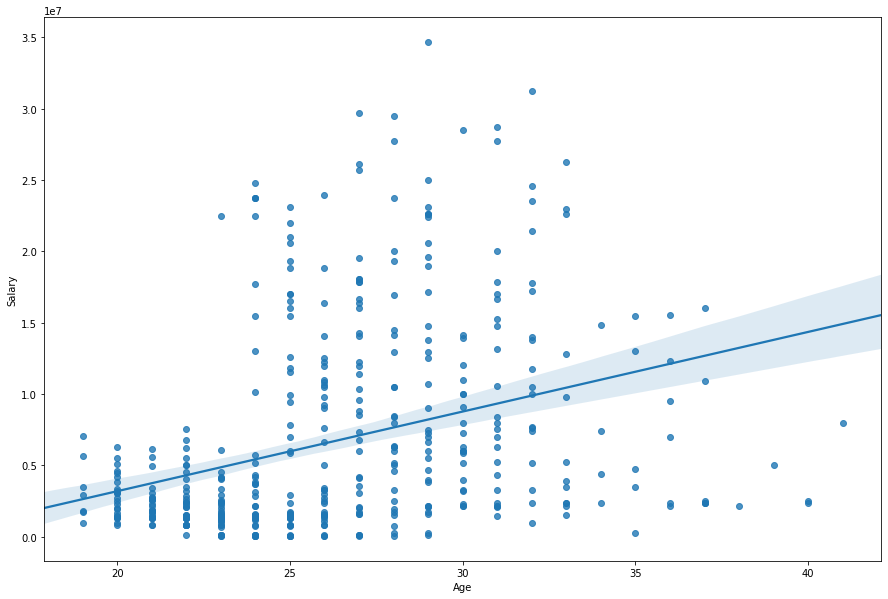

In [168]:
ax=sn.regplot(x='Age',y='Salary',data=data)

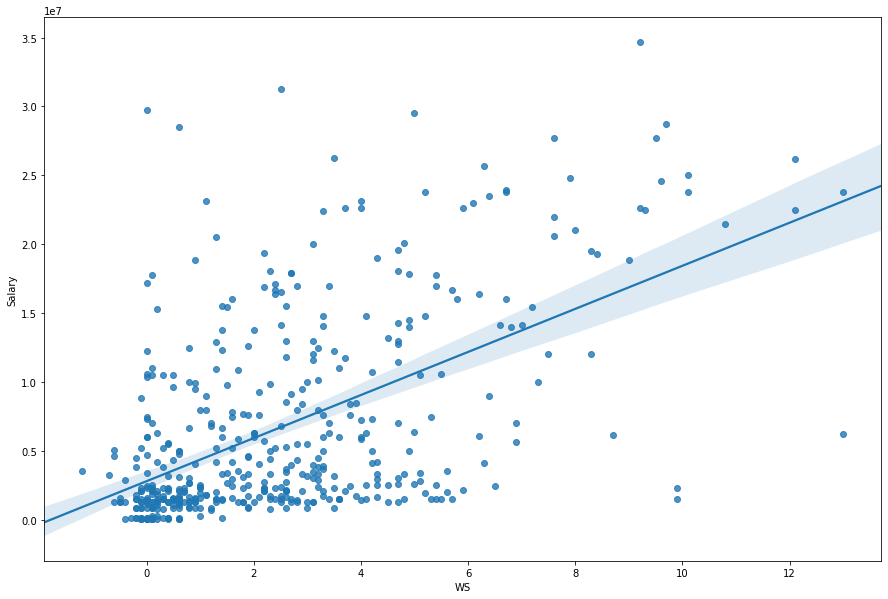

In [169]:
ax=sn.regplot(x='WS',y='Salary',data=data)

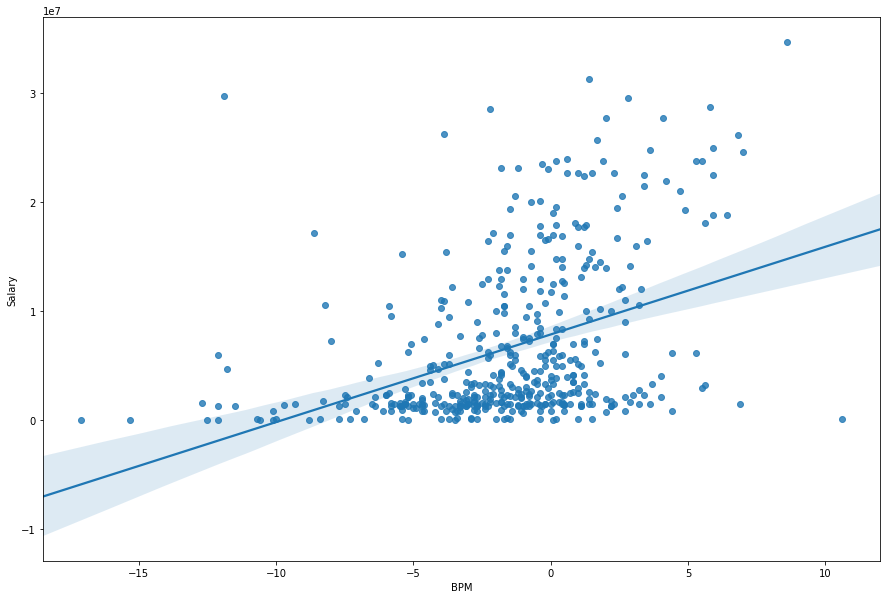

In [170]:
ax=sn.regplot(x='BPM',y='Salary',data=data)

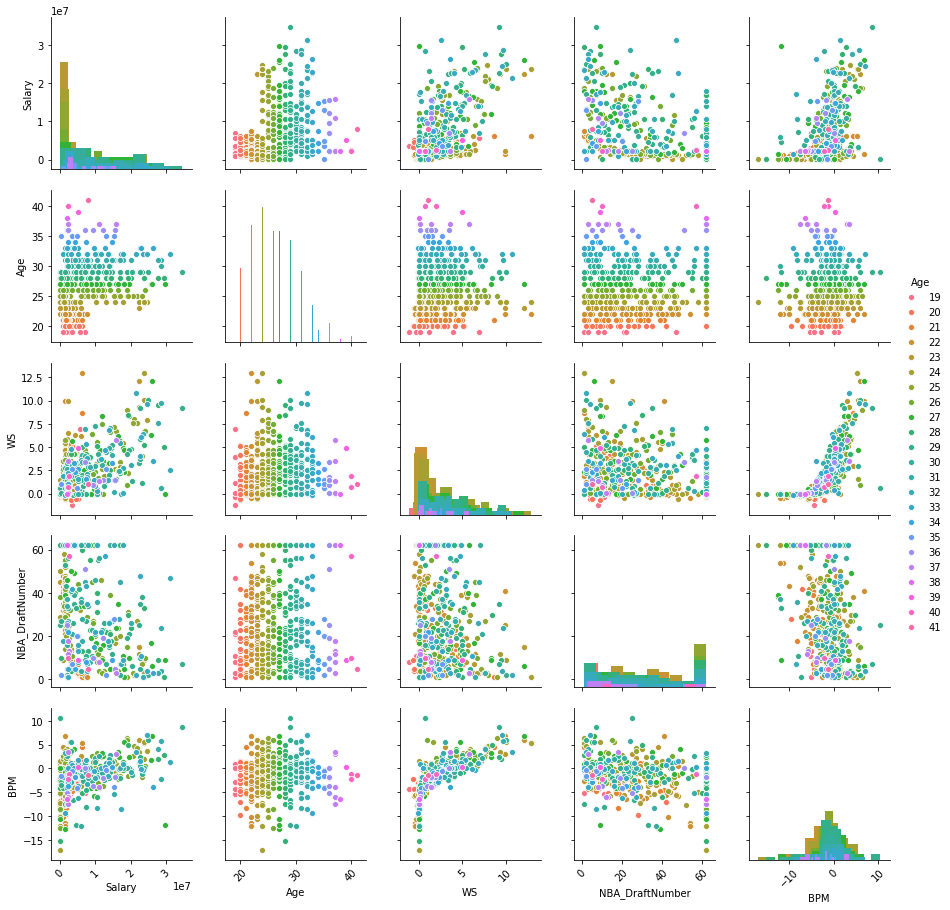

In [171]:
data_copy = data[['Salary','Age','WS','NBA_DraftNumber','BPM']]
graph = sn.pairplot(data_copy,hue='Age',diag_kind="hist")
for ax in graph.axes.flat:
    plt.setp(ax.get_xticklabels(),rotation=45)

In [172]:
pca = decomposition.PCA(n_components=3)

# Entrenamineto de los modelos

## Particiones

In [173]:
#x = data[['NBA_DraftNumber', 'Age', 'WS', 'BPM']] #features
#x = data[['Age', 'MP', 'OWS', 'DWS','WS','VORP']]
x = data.drop(['Salary','Player','NBA_Country', 'NBA_DraftNumber','Tm'],1)
y = data[['Salary']] #label

In [174]:
#spliting data into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

## Regresión Lineal Multiple

In [175]:
reg = LinearRegression(normalize=True)
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [176]:
train_y_pred = reg.predict(x_train)
test_y_pred = reg.predict(x_test)
print(train_y_pred.shape)
print(test_y_pred.shape)

(371, 1)
(93, 1)


In [177]:
print("MSE (train): %.4f" % mean_squared_error(y_train, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(y_test, test_y_pred))
print('R2  (train): %.4f' % r2_score(y_train, train_y_pred))
print('R2  (test) : %.4f' % r2_score(y_test, test_y_pred))

MSE (train): 25423858473741.7148
MSE (test) : 29495985988735.2188
R2  (train): 0.4896
R2  (test) : 0.5191


In [178]:
r2_aj_train = 1 - (1-r2_score(y_train, train_y_pred))*(len(y_train)-1) / (len(y_train) - x_train.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(y_test, test_y_pred))*(len(y_test)-1) / (len(y_test) - x_test.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

R2 adj (train): 0.4558
R2 adj (test): 0.3588


## Red Neuronal

In [179]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [100, 200, 300, 400, 500, 600, 700, 800, 900]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), (30, 20, 10), (30, 30, 30)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]

In [180]:
warnings.filterwarnings("ignore")

for k in activation_vec:
    mlp = MLPRegressor(activation=k, max_iter= 1000, hidden_layer_sizes=(30,30,30), random_state=1)
    mlp.fit(x_train,y_train.values.ravel())
    print(k,'R2: %.4f' % abs(mlp.score(x_test, y_test)))

logistic R2: 0.6759
relu R2: 0.2899
tanh R2: 0.6759


In [181]:
for k in max_iter_vec:
    mlp = MLPRegressor(activation='tanh', max_iter=k, hidden_layer_sizes=(30,30,30), random_state=1)
    mlp.fit(x_train,y_train.values.ravel())
    print(k,'R2: %.4f' % abs(mlp.score(x_test, y_test)))

100 R2: 0.6759
200 R2: 0.6759
300 R2: 0.6759
400 R2: 0.6759
500 R2: 0.6759
600 R2: 0.6759
700 R2: 0.6759
800 R2: 0.6759
900 R2: 0.6759


In [182]:
for k in hidden_layer_sizes_vec:
    mlp = MLPRegressor(activation='tanh', max_iter=800, hidden_layer_sizes=k, random_state=1)
    mlp.fit(x_train,y_train.values.ravel())
    print(k,'R2: %.4f' % abs(mlp.score(x_test, y_test)))

(10,) R2: 0.6759
(20,) R2: 0.6759
(30,) R2: 0.6759
(10, 10) R2: 0.6759
(20, 20) R2: 0.6759
(30, 30) R2: 0.6759
(20, 10) R2: 0.6759
(30, 20, 10) R2: 0.6759
(30, 30, 30) R2: 0.6759


In [ ]:
for k in learning_rate_init_vec:
    mlp = MLPRegressor(activation='tanh', max_iter=800, hidden_layer_sizes=(30,30,30), learning_rate_init=k, random_state=1)
    mlp.fit(x_train,y_train.values.ravel())
    print(k,'R2: %.4f' % abs(mlp.score(x_test, y_test)))

0.001 R2: 0.6759
0.002 R2: 0.6759
0.003 R2: 0.6759
0.004 R2: 0.6759
0.005 R2: 0.6758
0.006 R2: 0.6758
0.007 R2: 0.6758
0.008 R2: 0.6758


# KNN Regressor

In [ ]:
training_KNN = []
test_KNN = []
k_num = range(2,100)

In [ ]:
for num in k_num:
    knnR = KNeighborsRegressor(n_neighbors=num)
    knnR.fit(x_train, y_train)
    training_KNN.append(knnR.score(x_train, y_train))
    test_KNN.append(knnR.score(x_test, y_test))

In [ ]:
fig = plt.figure(figsize=(18,5))
fig.add_subplot(1, 2, 2)
grafico = plt.gca()
plt.plot(k_num, training_KNN)
plt.plot(k_num, test_KNN)
grafico.set_xlim(grafico.get_xlim()[::1])  
plt.legend(['Training', 'Test'])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('Score')

In [ ]:
best_k = k_num[np.argmax(test_KNN)]
best_s = max(test_KNN)
print("Mejor numero de vecinos:",best_k)
print("Mejor score:",best_s)

# 10 Fold Cross Validation

## Regresión Lineal Multiple

In [ ]:
reg = LinearRegression(normalize=True)
fold_Cross_Validation_reg = cross_val_score(knnR, x_train, y_train, cv=10)
score_average_reg = fold_Cross_Validation_reg.mean()

In [ ]:
cv = np.arange(0,10)
plt.scatter(cv, fold_Cross_Validation_reg)
plt.axis('tight')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.show()

In [ ]:
print("con el 10FCV se obtiene como score: ",score_average_reg)

## Red Neuronal 

In [ ]:
mlp = MLPRegressor(activation= 'logistic' , max_iter = 100, hidden_layer_sizes=(10, 10), learning_rate_init=0.001 , random_state=1)
fold_Cross_Validation_MLP = cross_val_score(mlp, x_train, y_train, cv=10)
score_average_MLP = fold_Cross_Validation_MLP.mean()

In [ ]:
cv = np.arange(0,10)
plt.scatter(cv, fold_Cross_Validation_MLP)
plt.axis('tight')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.show()

In [ ]:
print("con el 10FCV se obtiene como score: ",score_average_MLP)

## KNN Regressor

In [ ]:
knnR = KNeighborsRegressor(n_neighbors=best_k)
fold_Cross_Validation_KNN = cross_val_score(knnR, x_train, y_train, cv=10)
score_average_KNN = fold_Cross_Validation_KNN.mean()

In [ ]:
cv = np.arange(0,10)
plt.scatter(cv, fold_Cross_Validation_KNN)
plt.axis('tight')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.show()

In [ ]:
print("con el 10FCV se obtiene como score: ",score_average_KNN)